# Datos

In [1]:
# General Purpose
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

# FE
from CustomTransform import DistanceEncoder, SizeMeanEncoder, RangeEncoder, CustomKNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Cargamos los datos
dataTrain = pd.read_csv('depDataTrain_Arnau_20-08.csv')
dataTest = pd.read_csv('depDataTest_Arnau_20-08.csv')

In [3]:
dataTrain.head()

,ide_floor,ide_size,ide_price,ide_longitude,ide_latitude,his_quarterly_variation,his_price,his_monthly_variation,his_annual_variation,geo_distrito,...,dem_TamanoMedioDelHogar,dem_PropSinEstudiosUniversitarios,dem_PropSinEstudios,dem_Proporcion_de_nacidos_fuera_de_Espana,dem_PropConEstudiosUniversitarios,dem_PobTotal,dem_NumViviendas,dem_EdadMedia,dem_Densidad_(Habit/Ha),fe_micole_weights
0,3.0,141.0,990000.0,-3.656875,40.464347,2.2,3250,2.1,0.3,Hortaleza,...,2.527886,0.488949,0.175632,15.456193,0.335419,40838,16155.0,47.556540,161.894356,0.139147
1,2.0,159.0,940000.0,-3.703523,40.419427,1.4,5106,0.1,-4.3,Centro,...,1.975877,0.386598,0.083812,32.102460,0.529590,33418,16913.0,43.678945,352.500616,0.089744
2,NaN,92.0,549000.0,-3.669626,40.435362,0.6,4100,-0.2,-4.1,Salamanca,...,2.369951,0.365818,0.070351,18.224365,0.563831,42306,17851.0,46.477166,263.952286,0.105206
3,2.0,232.0,750000.0,-3.720619,40.424164,0.5,4773,0.3,-3.7,Moncloa - Aravaca,...,2.328217,0.343683,0.066403,20.963846,0.589914,24423,10490.0,46.972342,322.402577,0.083891
4,4.0,183.0,1550000.0,-3.705909,40.413214,-5.5,4739,-1.1,-5.3,Centro,...,1.994244,0.433750,0.082242,39.490947,0.484009,7622,3822.0,44.632774,171.165183,0.090978


In [5]:
dataTrain.columns

Index(['ide_floor', 'ide_size', 'ide_price', 'ide_longitude', 'ide_latitude',
       'his_quarterly_variation', 'his_price', 'his_monthly_variation',
       'his_annual_variation', 'geo_distrito', 'geo_barrio',
       'fe_places_weights_imputed',
       'dem_Indice_de_reemplazo_de_la_poblacion_activa',
       'dem_Indice_de_juventud',
       'dem_Indice_de_estructura_de_la_poblacion_activa',
       'dem_Indice_de_dependencia', 'dem_TasaDeParo',
       'dem_TamanoMedioDelHogar', 'dem_PropSinEstudiosUniversitarios',
       'dem_PropSinEstudios', 'dem_Proporcion_de_nacidos_fuera_de_Espana',
       'dem_PropConEstudiosUniversitarios', 'dem_PobTotal', 'dem_NumViviendas',
       'dem_EdadMedia', 'dem_Densidad_(Habit/Ha)', 'fe_micole_weights'],
      dtype='object')

# Modelado

In [3]:
# Train-Test target

target = 'ide_price'

y_train = dataTrain.pop(target)
X_train = dataTrain

y_test = dataTest.pop(target)
X_test = dataTest

### Transformers

In [4]:
# Distance Encoder:
distanceOrigin = [['sol', [40.414650, -3.700400]],
                  ['nmi', [40.446278, -3.691814]],
                  ['pca', [40.466070, -3.689280]]]
distanceEncoderColumn = ['ide_latitude', 'ide_longitude']
distanceEncoder = list()
for i in range(3):
    distanceEncoder.append(
        DistanceEncoder('fe_distance_' + distanceOrigin[i][0], distanceEncoderColumn, distanceOrigin[i][1]))

# Size Mean Encoder:
sizeMeanEncoderColumn = 'ide_size'
sizeMeanGroup = ['barrio', 'distrito']
sizeMeanEncoders = list()
for i in range(2):
    sizeMeanEncoders.append(
        SizeMeanEncoder('fe_mean_size_' + sizeMeanGroup[i], sizeMeanEncoderColumn, 'geo_' + sizeMeanGroup[i]))

# Range Enconders:
rangeEncoders = list()
rangeEncoders.append(RangeEncoder('fe_latitude_bins', 'ide_latitude', 10))
rangeEncoders.append(RangeEncoder('fe_longitude_bins', 'ide_longitude', 10))

# Custom KNNImputer
imputer = CustomKNNImputer(n_neighbors = 5, weights = 'distance')

# Column Transformer for OneHotEncoder
categorical_features = ['geo_distrito', 'geo_barrio', 'fe_latitude_bins', 'fe_longitude_bins']
oneHotColumnTransformer = ColumnTransformer([
    ("oneHotEncoder", OneHotEncoder(handle_unknown='ignore'),
     categorical_features)
], remainder = 'passthrough')

## Model Selection

In [5]:
""" Realizaremos un análisis de los siguientes modelos con las siguentes features """

seed = 42

models = []

models.append(('RFR1', RandomForestRegressor(n_estimators = 480,
                                            max_depth = None,
                                            max_features = 'auto',
                                            min_samples_split = 2,
                                            min_samples_leaf = 1,
                                            n_jobs = -1,
                                            random_state = 42)))

models.append(('RFR2', RandomForestRegressor(n_estimators = 460,
                                            max_depth = None,
                                            max_features = 'auto',
                                            min_samples_split = 2,
                                            min_samples_leaf = 1,
                                            n_jobs = -1,
                                            random_state = 42)))

In [6]:
metrics = []
metrics.append(('MAPE','neg_mean_absolute_percentage_error'))

In [7]:
""" Para plotear los resultados utilizaremos la siguiente función """

def boxplots_algorithms(results, names, metric, save_figure = False):
    
    if save_figure:
        # Export images
        if not os.path.exists("boxplots"):
            os.mkdir("boxplots")
        
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.title(metric)
    if save_figure:
        plt.savefig('boxplots/' + metric + '.jpg', transparent = True)
    plt.show() 

RFR1: -0.169001 (0.001359)
RFR2: -0.169014 (0.001347)


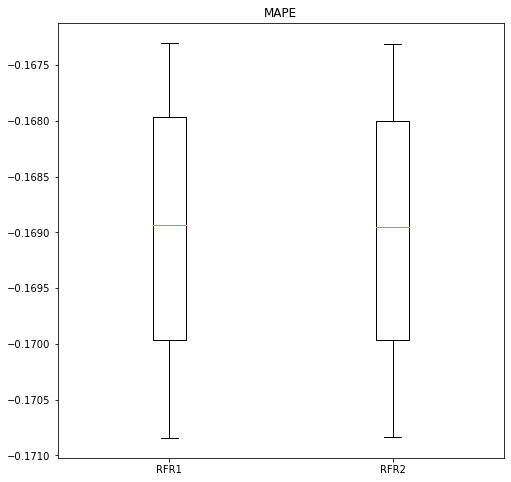

In [8]:
for metric, scoring in metrics:
    results = []
    names = []
    for name, model in models:

        pipeline = Pipeline([('Encoder1', distanceEncoder[0]),
                             ('Encoder2', distanceEncoder[1]),
                             ('Encoder3', distanceEncoder[2]),
                             ('Encoder4', sizeMeanEncoders[0]),
                             ('Encoder5', sizeMeanEncoders[1]),
                             ('Encoder6', rangeEncoders[0]),
                             ('Encoder7', rangeEncoders[1]),
                             ('Imputer1', imputer),
                             ('Encoder8', oneHotColumnTransformer),
                            # ('scaler', RobustScaler(with_centering = False)), # False for sparse matrix
                             ('Model', model)])

        cv_technique = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(pipeline,           # Pipeline
                                     X_train,           # Feature matrix
                                     y_train,             # Target vector
                                     cv=cv_technique,    # Cross-validation technique
                                     scoring=scoring, # scoring
                                     n_jobs = -1) 

        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        results.append(cv_results)
        names.append(name)

    boxplots_algorithms(results, names, metric, save_figure = False)

### Evaluación TEST con MAPE

In [9]:
for name, model in models:

    pipeline = Pipeline([('Encoder1', distanceEncoder[0]),
                         ('Encoder2', distanceEncoder[1]),
                         ('Encoder3', distanceEncoder[2]),
                         ('Encoder4', sizeMeanEncoders[0]),
                         ('Encoder5', sizeMeanEncoders[1]),
                         ('Encoder6', rangeEncoders[0]),
                         ('Encoder7', rangeEncoders[1]),
                         ('Imputer1', imputer),
                         ('Encoder8', oneHotColumnTransformer),
                        # ('scaler', RobustScaler(with_centering = False)), # False for sparse matrix
                         ('Model', model)])

    pipeline.fit(X_train, y_train)
    dataTest_y_PRED = pipeline.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, dataTest_y_PRED)

    msg = "%s: %f" % (name, mape)
    print(msg)

RFR1: 0.164048
RFR2: 0.163976
